# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

Код для расчёта энтропии:

In [3]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

In [4]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.33, random_state = 42)

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики точность (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [5]:
class MyTree:
  def __init__(self, probabilities = None):
    self.right = None
    self.left = None
    self.probabilities = probabilities
    self.col = None
    self.t = -1
    self.depth = 1
    self.is_stoped = False
  def grow(self, probabilities):
    node = MyTree()
    node.probabilities = probabilities
    self.depth += 1
    return node

Реализовал с критериями:
* максимальной глубины дерева
* минимального числа объектов в листе
* максимальное количество листьев в дереве

In [6]:
class MyDecisionTreeClassifier:
  def __init__(self, max_depth, min_samples_leaf, max_leaf_nodes):
    self.tree = None
    self.y = None
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.max_leaf_nodes = max_leaf_nodes

  def probabilities(self, y):
    return np.array([len(y[y == y_type]) / len(y) for y_type in np.unique(self.y)])
      
  def ig(self, r_v, r_left, r_right):
    return entropy(r_v) - ((len(r_left) / len(r_v) * entropy(r_left)) + (len(r_right) / len(r_v) * entropy(r_right)))
  
  def split_node(self, X, y, node):
    if node.depth >= self.max_depth or len(X) < self.max_leaf_nodes or len(np.unique(y)) == 1:
      node.is_stoped = True
      return
    best_split_col = None
    best_t = None
    best_ig = -1
    best_sample1, best_sample2, x1, x2 = [], [], [], []
    for col in range(X.shape[1]):
      x_col = X[:, col]
      for t in x_col:
        sample1, sample2 = y[x_col < t], y[x_col >= t]       
        if len(sample1) == 0 or len(sample2) == 0: continue
        ig = self.ig(y, sample1, sample2)
        if ig > best_ig:
          best_t, best_ig, best_sample1, best_sample2, best_split_col = t, ig, sample1, sample2, col 
          x1, x2, x_col = X[x_col < best_t, :], X[x_col >= best_t, :], X[:, best_split_col]
      if len(x1) < self.min_samples_leaf or len(x2) < self.min_samples_leaf:
          node.is_stoped = True
          return
      node.left = node.grow(self.probabilities(best_sample1))
      node.right = node.grow(self.probabilities(best_sample2))
      node.col = best_split_col
      node.t = best_t
      self.split_node(x2, best_sample2, node.right)
      self.split_node(x1, best_sample1, node.left)
  
  def fit(self, X, y):
      self.y = y
      self.tree = MyTree(self.probabilities(y))
      self.split_node(np.asarray(X), y, self.tree)
  
  def predict(self, X):
      return [np.argmax(self.predict_node(x, self.tree)) for x in np.asarray(X)]
  
  def predict_node(self, x, node):
    if node.is_stoped:
      return node.probabilities
    elif x[node.col] > node.t:
      return self.predict_node(x, node.right)
    else:
      return self.predict_node(x, node.left)

Моя версия:

In [ ]:
myTree = MyDecisionTreeClassifier(5, 5, 5)
myTree.fit(X_train, y_train)

y_pred = myTree.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

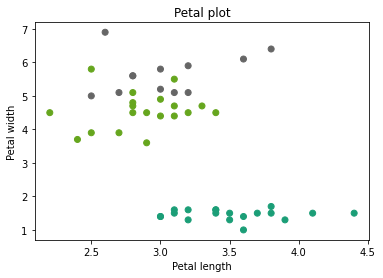

In [ ]:
plt.scatter(X_test[:, 1], X_test[:, 2], c = y_pred, cmap = plt.cm.Dark2)
plt.title("Petal plot")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.show()

SkLearn версия:

In [ ]:
skTree = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 5, max_leaf_nodes = 5)
skTree.fit(X_train, y_train)

y_pred = skTree.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

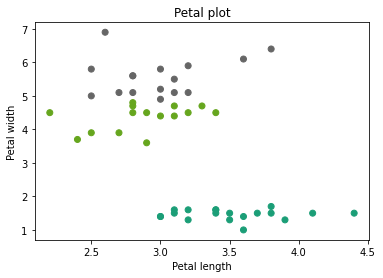

In [ ]:
plt.scatter(X_test[:, 1], X_test[:, 2], c = y_pred, cmap = plt.cm.Dark2)
plt.title("Petal plot")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.show()

##Вывод

Сравнив модели по метрике точности `accuracy_score`, можно сказать, что реализация с `sklearn` на $ 8\% $ лучше моей(. Визуально это можно заметить, сравнив графики

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

In [7]:
pip install category_encoders

     |████████████████████████████████| 82 kB 302 kB/s 


In [8]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
churn = pd.read_csv("/content/drive/MyDrive/churn.csv", sep = ",")

In [10]:
churn_target = churn["Exited"]
churn["Gender"] = TargetEncoder().fit_transform(churn["Gender"], churn_target)
churn["Geography"] = TargetEncoder().fit_transform(churn["Geography"], churn_target)
churn_data = churn.drop(["RowNumber", "Surname", "CustomerId", "Exited"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(churn_data, churn_target, test_size = 0.33, random_state = 42)

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [13]:
class MyRandomForestClassifier:
  def __init__(self, tree_count=100, max_depth=5, min_samples_leaf=5):
    self.tree_count = tree_count
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf

    self.trees = []

  def fit(self, X, y):
    n = len(X)
    features = int(np.sqrt(X.shape[1]))
    for i in range (0, self.tree_count):
      seed = np.random.randint(1, 1000)
      X_sample = X.sample(n=n, random_state=seed)
      y_sample = y.sample(n=n, random_state=seed)
      tree = DecisionTreeClassifier(max_features=features, max_depth=self.max_depth, min_samples_split=self.min_samples_leaf)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)

  def predict(self, X):
    votes = []
    for tree in self.trees:
      votes.append(tree.predict(X))
    votes = pd.DataFrame(data = votes)
    return round(votes.mean())

  def feature_importances(self):
    votes = []
    for tree in self.trees:
      votes.append(tree.feature_importances_)
    votes = pd.DataFrame(data = votes)
    return votes.mean()

Подбор гиперпараметров:

In [22]:
def get_best_hyper_param():
  best_score = 0
  best_max_tree = 0
  best_max_depth = 0 
  best_min_samples_leaf = 0 
  for max_tree in [100, 200, 500]:
    for max_depth in range(1, 10):
      for min_samples_leaf in range(2, 4):
        myForest = MyRandomForestClassifier(max_tree, max_depth, min_samples_leaf)
        myForest.fit(X_train, y_train)
        y_pred = myForest.predict(X_test)
        current_score = accuracy_score(y_test, y_pred)
        if current_score > best_score:
          best_score = current_score
          best_max_tree = max_tree
          best_max_depth = max_depth 
          best_min_samples_leaf = min_samples_leaf
  return best_max_tree, best_max_depth, best_min_samples_leaf

In [ ]:
best_max_tree, best_max_depth, best_min_samples_leaf = get_best_hyper_param()

Моя версия:

In [25]:
myForest = MyRandomForestClassifier(best_max_tree, best_max_depth, best_min_samples_leaf)
myForest.fit(X_train, y_train)

y_pred = myForest.predict(X_test)
accuracy_score(y_test, y_pred)  

0.8672727272727273

In [ ]:
pd.DataFrame(data = np.c_[X_test.columns, myForest.feature_importances()], columns = ["Feature", "Importance"]).sort_values(by = "Importance", ascending=False)

,Feature,Importance
3,Age,0.235078
9,EstimatedSalary,0.147938
0,CreditScore,0.145271
5,Balance,0.144548
6,NumOfProducts,0.128656
4,Tenure,0.0816248
8,IsActiveMember,0.0419088
1,Geography,0.0400392
7,HasCrCard,0.0182578
2,Gender,0.0166792


SkLearn версия:

In [ ]:
skForest = RandomForestClassifier(best_max_tree)
skForest.fit(X_train, y_train)

y_pred = skForest.predict(X_test)
accuracy_score(y_test, y_pred)  

0.8678787878787879

In [ ]:
pd.DataFrame(data = np.c_[X_test.columns, skForest.feature_importances_], columns = ["Feature", "Importance"]).sort_values(by = "Importance", ascending=False)

,Feature,Importance
3,Age,0.233364
9,EstimatedSalary,0.145593
0,CreditScore,0.142516
5,Balance,0.142212
6,NumOfProducts,0.128529
4,Tenure,0.0817211
8,IsActiveMember,0.0438901
1,Geography,0.0422562
7,HasCrCard,0.020043
2,Gender,0.0198762


##Вывод

Сравнив модели по метрике точности `accuracy_score`, можно сказать, что реализация случайного леса с `sklearn` на $ 1\% $ лучше моей реалезации, т.е результаты алгоритмов должны быть схожими. Это действительно так, если посмотреть и сравнить на таблицы с признаками, то увидим, что порядок важности признаков одинаковый, а значения признаков различаются в 3-ем порядке. Самым важным признаком является $\text{Age}$ (возраст)

Лучшие параметры гиперпараметры оказались:
* количество деревьев = 500
* максимальной глубины дерева = 2
* минимального числа объектов в листе = 2